In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np 
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

## Load the training data into feature matrix, class labels, and event ids:

In [2]:
from proj1_helpers import *
DATA_TRAIN_PATH = 'C:\\Users\\asus\\Documents\\GitHub\\ML_course\\projects\\project1\\data\\train.csv' # TODO: download train data and supply path here 
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)

## Do your thing crazy machine learning thing here :) ...

In [3]:
from implementations import *

In [4]:
#Normalize the data
centered_data = tX - np.mean(tX, axis=0)
tX = centered_data / np.std(centered_data, axis=0)
y[y == -1] = 0

In [5]:
#Find the correlations btw all columns and delete rows that are highly correlated
corr_mtx = np.identity(30)
for i in range(31):
    for j in range(i,30):
        corr_mtx[i,j] = np.corrcoef(tX[:,i], tX[:,j])[0,1]
        if corr_mtx[i,j]>0.95 and i!=j:
            print(i,j)

4 6
4 12
4 26
4 27
4 28
6 12
6 26
6 27
6 28
9 29
12 26
12 27
12 28
23 24
23 25
24 25
26 27
26 28
27 28


In [6]:
tX = np.delete(tX, np.array([6, 12,24,25,26,27,28,29]), axis=1)

In [7]:
least_squares_GD(y, tX, np.ones(tX.shape[1]), 50, 0.3)

(array([ 4.74321259e-02, -1.53963212e-01, -1.37635737e-01,  1.33744517e-01,
         8.92468835e-02,  2.69903296e-01,  7.71949367e-02,  6.08511647e-02,
         4.22754698e-02,  1.54108065e-03,  1.38481014e-01,  2.28383070e-01,
         4.78779208e-04,  1.48033753e-04,  1.33319320e-01,  1.64120780e-03,
         9.00020726e-04,  1.25322046e-01,  1.80818705e-03,  8.89206402e-02,
         1.77560082e-02,  1.94047648e-01]), 1.132196427852129)

0.2945519130787804

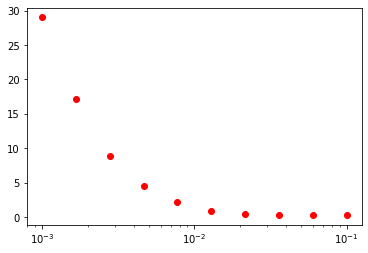

In [8]:
num_gamma = 10
least_squares_loss = np.ones(num_gamma)
gamma = np.logspace(-3, -1, num_gamma)
for i in range(num_gamma):
    least_squares_loss[i] = least_squares_GD(y, tX, np.ones(tX.shape[1]), 100, gamma[i])[1]
plt.plot(gamma, least_squares_loss, 'ro')
plt.xscale('log')
np.min(least_squares_loss)

In [9]:
least_squares_SGD(y, tX, np.ones(tX.shape[1]), 200, 0.3)

(array([-1.63558483e+36, -1.58028818e+36, -9.11379673e+35, -9.09855532e+34,
        -1.97494806e+35, -2.79893350e+35, -7.34168307e+35, -7.44939125e+35,
        -5.23057034e+35, -1.40520559e+36, -1.56277002e+35, -5.72984527e+35,
         3.54107201e+35, -1.55479738e+35, -1.88677199e+36,  9.71227125e+34,
         1.34741677e+36, -2.99397443e+35, -1.48784729e+36, -2.67267639e+35,
        -2.44540147e+34,  4.61366082e+35]), 3.047099836278917e+73)

0.4383246141539431

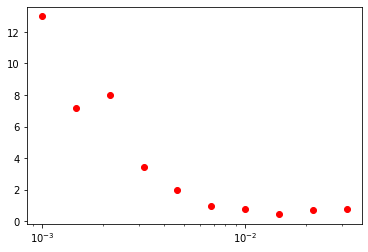

In [10]:
num_gamma = 10
least_squares_loss_SG = np.ones(num_gamma)
gamma = gamma = np.logspace(-3, -1.5, num_gamma)
for i in range(num_gamma):
    least_squares_loss_SG[i] = least_squares_SGD(y, tX, np.ones(tX.shape[1]), 200, gamma[i])[1]
plt.plot(gamma, least_squares_loss_SG, 'ro')
plt.xscale('log')
np.min(least_squares_loss_SG)

In [11]:
least_squares(y, tX)

(array([ 0.01457775, -0.12673899, -0.12745413, -0.01694001, -0.08993026,
         0.20927023,  0.13388932, -0.00050725, -0.07308316, -0.09132203,
         0.05763819,  0.11023857, -0.00032171, -0.00054586,  0.15797759,
        -0.00043332,  0.0012556 ,  0.06044576,  0.00050283, -0.03165107,
        -0.09071907,  0.07996976]), 0.28744464469757697)

In [12]:
ridge_regression(y, tX, 0.02)

(array([ 0.02074855, -0.11421443, -0.0920186 , -0.00077868, -0.04247097,
         0.13761996,  0.10431579, -0.00810759, -0.03863204, -0.06988994,
         0.05813532,  0.09582814, -0.00044968, -0.00074823,  0.10749807,
        -0.00036194,  0.00119516,  0.04380157,  0.00059088, -0.03638813,
        -0.06717489,  0.05004489]), 0.2906412127080359)

0.28744640480134276

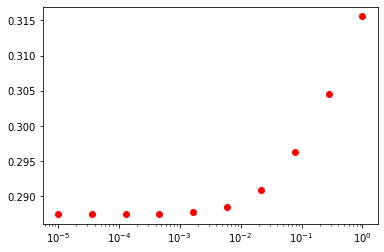

In [13]:
num_lambda = 10
ridge_regression_loss = np.ones(num_lambda)
lambda_ =  np.logspace(-5, 0, num_lambda)
for i in range(num_lambda):
    ridge_regression_loss[i] = ridge_regression(y, tX, lambda_[i])[1]
plt.plot(lambda_, ridge_regression_loss, 'ro')
plt.xscale('log')
np.min(ridge_regression_loss)

In [22]:
from implementations import *

In [46]:
tX.shape

(250000, 22)

In [62]:
logistic_regression(y[0:10000], tX[0:10000], np.zeros(tX.shape[1]), 1000, 0.1)

Current iteration=0, loss=0.9497155280073354
Current iteration=100, loss=0.533591487734646
Current iteration=200, loss=0.5171115961195137
Current iteration=300, loss=0.5110867008978482
Current iteration=400, loss=0.5073151771559897
Current iteration=500, loss=0.5046186720768737
Current iteration=600, loss=0.5025926807112129
Current iteration=700, loss=0.5010293510818333
Current iteration=800, loss=0.49980068413083856
Current iteration=900, loss=0.4988210099018108


(array([-0.9169806 ,  0.29675215, -0.59338234, -0.71687223,  0.22910409,
        -0.26619981,  0.84045467,  0.7957963 , -0.09206252, -0.11358649,
        -0.5328816 ,  0.22798553,  0.55051544,  0.01781414,  0.01995461,
         0.66872307,  0.00567693,  0.04015815,  0.15556971, -0.02017552,
        -0.25749664, -0.49723412,  0.31439032]), 0.49803758891723465)

In [66]:
reg_logistic_regression(y[0:10000], tX[0:10000], 0.01, np.zeros(tX.shape[1]), 1000, 0.1)

Current iteration=0, loss=0.9539398063104739
Current iteration=100, loss=0.5395660521557003
Current iteration=200, loss=0.5271892589649284
Current iteration=300, loss=0.523649381289866
Current iteration=400, loss=0.521861833846568
Current iteration=500, loss=0.5208350365860617
Current iteration=600, loss=0.5202190673051714
Current iteration=700, loss=0.5198415431430097
Current iteration=800, loss=0.5196069646923832
Current iteration=900, loss=0.5194597197160823


(array([-0.82616977,  0.27265324, -0.53920538, -0.47023402,  0.19455937,
        -0.15929916,  0.60336106,  0.58129183, -0.09475489, -0.06850076,
        -0.40949292,  0.22748089,  0.45639004,  0.01648466,  0.01764072,
         0.44236985,  0.00377124,  0.03691431,  0.13169761, -0.01737231,
        -0.20136819, -0.35467339,  0.19940319]), 0.5193672771369832)

Current iteration=0, loss=964.2117387941635
Current iteration=100, loss=959.2417163249756
Current iteration=200, loss=954.3204253712114
Current iteration=300, loss=949.4471635055088
Current iteration=400, loss=944.6212398324243
Current iteration=500, loss=939.8419752741988
Current iteration=600, loss=935.1087027412831
Current iteration=700, loss=930.4207672069914
Current iteration=800, loss=925.7775257044509
Current iteration=900, loss=921.1783472624984
Current iteration=1000, loss=916.6226127955216
Current iteration=1100, loss=912.1097149604875
Current iteration=1200, loss=907.6390579926485
Current iteration=1300, loss=903.2100575296865
Current iteration=1400, loss=898.8221404324252
Current iteration=1500, loss=894.4747446087093
Current iteration=1600, loss=890.1673188456361
Current iteration=1700, loss=885.899322654069
Current iteration=1800, loss=881.6702261282107
Current iteration=1900, loss=877.4795098220479
Current iteration=2000, loss=873.326664643582
Current iteration=2100, los

Current iteration=9200, loss=621.1013808080296
Current iteration=9300, loss=619.0007536769708
Current iteration=9400, loss=616.9300179512554
Current iteration=9500, loss=614.8890472041054
Current iteration=9600, loss=612.877712463586
Current iteration=9700, loss=610.8958821601927
Current iteration=9800, loss=608.9434220772885
Current iteration=9900, loss=607.0201953037947
Current iteration=0, loss=964.19306804235
Current iteration=100, loss=957.3779364928915
Current iteration=200, loss=950.6542804140865
Current iteration=300, loss=944.020295195334
Current iteration=400, loss=937.4742180520634
Current iteration=500, loss=931.0143289101003
Current iteration=600, loss=924.6389506592711
Current iteration=700, loss=918.346448939315
Current iteration=800, loss=912.1352316013076
Current iteration=900, loss=906.0037479659748
Current iteration=1000, loss=899.9504879781832
Current iteration=1100, loss=893.9739813357824
Current iteration=1200, loss=888.0727966516075
Current iteration=1300, loss=8

Current iteration=8400, loss=579.5113653414963
Current iteration=8500, loss=577.5406360054159
Current iteration=8600, loss=575.6191714403221
Current iteration=8700, loss=573.7464506104802
Current iteration=8800, loss=571.9219386825085
Current iteration=8900, loss=570.1450866228478
Current iteration=9000, loss=568.4153307774877
Current iteration=9100, loss=566.7320924351714
Current iteration=9200, loss=565.0947773757047
Current iteration=9300, loss=563.5027754054714
Current iteration=9400, loss=561.9554598827789
Current iteration=9500, loss=560.4521872362886
Current iteration=9600, loss=558.9922964804762
Current iteration=9700, loss=557.575108732903
Current iteration=9800, loss=556.1999267390131
Current iteration=9900, loss=554.8660344112621
Current iteration=0, loss=964.1674188460728
Current iteration=100, loss=954.8286908067842
Current iteration=200, loss=945.6613272128033
Current iteration=300, loss=936.6607095532677
Current iteration=400, loss=927.8223705776063
Current iteration=500

Current iteration=6400, loss=572.0512347753727
Current iteration=6500, loss=569.6176234747663
Current iteration=6600, loss=567.2725722798937
Current iteration=6700, loss=565.0145609908203
Current iteration=6800, loss=562.84201304084
Current iteration=6900, loss=560.7532931822035
Current iteration=7000, loss=558.7467051275655
Current iteration=7100, loss=556.8204891856444
Current iteration=7200, loss=554.9728199406844
Current iteration=7300, loss=553.2018040387577
Current iteration=7400, loss=551.5054781600377
Current iteration=7500, loss=549.8818072751235
Current iteration=7600, loss=548.3286833053559
Current iteration=7700, loss=546.8439243315415
Current iteration=7800, loss=545.4252745218737
Current iteration=7900, loss=544.0704049767062
Current iteration=8000, loss=542.7769157128906
Current iteration=8100, loss=541.54233903024
Current iteration=8200, loss=540.3641445126332
Current iteration=8300, loss=539.2397459104434
Current iteration=8400, loss=538.1665101225591
Current iteration

Current iteration=4100, loss=593.8087586535081
Current iteration=4200, loss=589.4956884963703
Current iteration=4300, loss=585.3678405252897
Current iteration=4400, loss=581.4221609407412
Current iteration=4500, loss=577.6554420636164
Current iteration=4600, loss=574.0643146854061
Current iteration=4700, loss=570.6452395610958
Current iteration=4800, loss=567.3944980473636
Current iteration=4900, loss=564.3081819414848
Current iteration=5000, loss=561.3821826368135
Current iteration=5100, loss=558.6121797850126
Current iteration=5200, loss=555.9936297506284
Current iteration=5300, loss=553.5217542682444
Current iteration=5400, loss=551.1915298747241
Current iteration=5500, loss=548.9976788964275
Current iteration=5600, loss=546.9346630278815
Current iteration=5700, loss=544.9966808409989
Current iteration=5800, loss=543.1776708956478
Current iteration=5900, loss=541.4713224439741
Current iteration=6000, loss=539.8710959613405
Current iteration=6100, loss=538.3702557862815
Current itera

Current iteration=3200, loss=581.5536986742092
Current iteration=3300, loss=576.4159113380732
Current iteration=3400, loss=571.6072779823535
Current iteration=3500, loss=567.1183770872191
Current iteration=3600, loss=562.9391221311826
Current iteration=3700, loss=559.0587089743258
Current iteration=3800, loss=555.4655602088261
Current iteration=3900, loss=552.1472694753496
Current iteration=4000, loss=549.090550562878
Current iteration=4100, loss=546.2811986589624
Current iteration=4200, loss=543.7040744817489
Current iteration=4300, loss=541.3431260131207
Current iteration=4400, loss=539.1814663943063
Current iteration=4500, loss=537.2015285198328
Current iteration=4600, loss=535.385314125174
Current iteration=4700, loss=533.7147443526037
Current iteration=4800, loss=532.1720981140131
Current iteration=4900, loss=530.7404971009018
Current iteration=5000, loss=529.4043718749045
Current iteration=5100, loss=528.1498355546715
Current iteration=5200, loss=526.9649083182821
Current iterati

Current iteration=2200, loss=544.88554237944
Current iteration=2300, loss=540.4164044040223
Current iteration=2400, loss=536.6308113174538
Current iteration=2500, loss=533.408739391914
Current iteration=2600, loss=530.6311457295402
Current iteration=2700, loss=528.190690810222
Current iteration=2800, loss=526.0008945609592
Current iteration=2900, loss=523.9993853754911
Current iteration=3000, loss=522.1450214150827
Current iteration=3100, loss=520.4121373759068
Current iteration=3200, loss=518.7850159055172
Current iteration=3300, loss=517.2538513456636
Current iteration=3400, loss=515.8121924139815
Current iteration=3500, loss=514.4554431459063
Current iteration=3600, loss=513.1800229833793
Current iteration=3700, loss=511.98291029626364
Current iteration=3800, loss=510.86140076932094
Current iteration=3900, loss=509.8129831554494
Current iteration=4000, loss=508.83527757074353
Current iteration=4100, loss=507.9260060877336
Current iteration=4200, loss=507.0829792706819
Current iterat

Current iteration=3200, loss=501.9963304389411
Current iteration=3300, loss=501.6010184734452
Current iteration=3400, loss=501.32191409926526
Current iteration=3500, loss=501.15133401256946
Current iteration=3600, loss=501.07883862739305
Current iteration=3700, loss=501.07179353210887
Current iteration=3800, loss=501.07034423593154
Current iteration=3900, loss=501.0699973374725
Current iteration=4000, loss=501.069910700316
Current iteration=4100, loss=501.06988882867074
Current iteration=0, loss=963.5192844145774
Current iteration=100, loss=894.4243824973726
Current iteration=200, loss=834.2162864826107
Current iteration=300, loss=781.3453603818148
Current iteration=400, loss=734.7560901945276
Current iteration=500, loss=693.826412555952
Current iteration=600, loss=658.2201374490776
Current iteration=700, loss=627.7182928762629
Current iteration=800, loss=602.1036144282226
Current iteration=900, loss=581.1062958144288
Current iteration=1000, loss=564.3812808473608
Current iteration=110

Current iteration=1400, loss=501.07249366757884
Current iteration=1500, loss=501.07173806128424
Current iteration=1600, loss=501.07155236884194
Current iteration=1700, loss=501.07150567963015
Current iteration=1800, loss=501.07149387301956
Current iteration=1900, loss=501.0714908830705
Current iteration=2000, loss=501.071490125594
Current iteration=2100, loss=501.07148993367286
Current iteration=2200, loss=501.0714898850444
Current iteration=2300, loss=501.0714898727228
Current iteration=2400, loss=501.0714898696008
Current iteration=2500, loss=501.0714898688097
Current iteration=2600, loss=501.07148986860926
Current iteration=2700, loss=501.0714898685585
Current iteration=2800, loss=501.0714898685456
Current iteration=2900, loss=501.0714898685423
Current iteration=3000, loss=501.07148986854156
Current iteration=3100, loss=501.07148986854133
Current iteration=3200, loss=501.0714898685412
Current iteration=3300, loss=501.0714898685413
Current iteration=3400, loss=501.0714898685412
Curre

Current iteration=8900, loss=501.07216193751907
Current iteration=9000, loss=501.07216193751907
Current iteration=9100, loss=501.07216193751907
Current iteration=9200, loss=501.07216193751907
Current iteration=9300, loss=501.07216193751907
Current iteration=9400, loss=501.07216193751907
Current iteration=9500, loss=501.07216193751907
Current iteration=9600, loss=501.07216193751907
Current iteration=9700, loss=501.07216193751907
Current iteration=9800, loss=501.07216193751907
Current iteration=9900, loss=501.07216193751907
Current iteration=0, loss=961.622060527104
Current iteration=100, loss=753.280067384193
Current iteration=200, loss=623.5980012350576
Current iteration=300, loss=554.8555206383603
Current iteration=400, loss=528.3338627387449
Current iteration=500, loss=516.2980797886396
Current iteration=600, loss=508.4829751586954
Current iteration=700, loss=503.7386623657561
Current iteration=800, loss=501.46920664899204
Current iteration=900, loss=501.09719793372227
Current iterat

Current iteration=6500, loss=501.0743640688337
Current iteration=6600, loss=501.0743640688337
Current iteration=6700, loss=501.0743640688337
Current iteration=6800, loss=501.0743640688337
Current iteration=6900, loss=501.0743640688337
Current iteration=7000, loss=501.0743640688337
Current iteration=7100, loss=501.0743640688337
Current iteration=7200, loss=501.0743640688337
Current iteration=7300, loss=501.0743640688337
Current iteration=7400, loss=501.0743640688337
Current iteration=7500, loss=501.0743640688337
Current iteration=7600, loss=501.0743640688337
Current iteration=7700, loss=501.0743640688337
Current iteration=7800, loss=501.0743640688337
Current iteration=7900, loss=501.0743640688337
Current iteration=8000, loss=501.0743640688337
Current iteration=8100, loss=501.0743640688337
Current iteration=8200, loss=501.0743640688337
Current iteration=8300, loss=501.0743640688337
Current iteration=8400, loss=501.0743640688337
Current iteration=8500, loss=501.0743640688337
Current itera

Current iteration=5800, loss=501.07850137889693
Current iteration=5900, loss=501.07850137889693
Current iteration=6000, loss=501.07850137889693
Current iteration=6100, loss=501.07850137889693
Current iteration=6200, loss=501.07850137889693
Current iteration=6300, loss=501.07850137889693
Current iteration=6400, loss=501.07850137889693
Current iteration=6500, loss=501.07850137889693
Current iteration=6600, loss=501.07850137889693
Current iteration=6700, loss=501.07850137889693
Current iteration=6800, loss=501.07850137889693
Current iteration=6900, loss=501.07850137889693
Current iteration=7000, loss=501.07850137889693
Current iteration=7100, loss=501.07850137889693
Current iteration=7200, loss=501.07850137889693
Current iteration=7300, loss=501.07850137889693
Current iteration=7400, loss=501.07850137889693
Current iteration=7500, loss=501.07850137889693
Current iteration=7600, loss=501.07850137889693
Current iteration=7700, loss=501.07850137889693
Current iteration=7800, loss=501.0785013

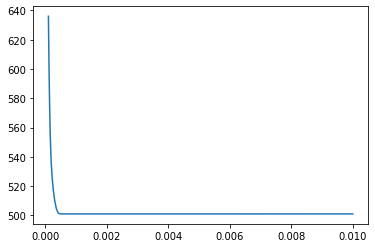

In [48]:
e1 = cross_validation_demo(y[0:1000], tX[0:1000])

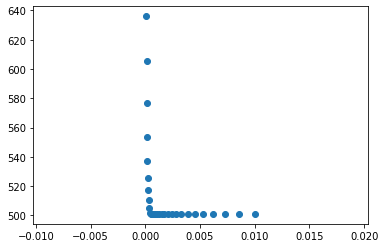

In [50]:
plt.scatter(np.logspace(-4, -2, 30),(e1))

## Generate predictions and save ouput in csv format for submission:

In [10]:
DATA_TEST_PATH = '' # TODO: download train data and supply path here 
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)

In [31]:
OUTPUT_PATH = '' # TODO: fill in desired name of output file for submission
y_pred = predict_labels(weights, tX_test)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)